In [31]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

data = pd.read_csv('Houses.csv', encoding='latin-1')

In [32]:
data.head()

,Unnamed: 0,address,city,floor,id,latitude,longitude,price,rooms,sq,year
0,0,Podgórze Zab³ocie Stanis³awa Klimeckiego,Kraków,2.0,23918.0,50.049224,19.970379,749000.0,3.0,74.05,2021.0
1,1,Praga-Po³udnie Grochowska,Warszawa,3.0,17828.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0
2,2,Krowodrza Czarnowiejska,Kraków,2.0,22784.0,50.066964,19.920025,427000.0,2.0,37.00,1970.0
3,3,Grunwald,Poznañ,2.0,4315.0,52.404212,16.882542,1290000.0,5.0,166.00,1935.0
4,4,Ochota Gotowy budynek. Stan deweloperski. Osta...,Warszawa,1.0,11770.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0


In [33]:
data.dtypes

Unnamed: 0      int64
address        object
city           object
floor         float64
id            float64
latitude      float64
longitude     float64
price         float64
rooms         float64
sq            float64
year          float64
dtype: object

In [34]:
data.duplicated().sum()


0

In [35]:
data.isna().sum()

Unnamed: 0    0
address       0
city          0
floor         0
id            0
latitude      0
longitude     0
price         0
rooms         0
sq            0
year          0
dtype: int64


#### Cleaning the data

In [36]:
ndc = data.copy(deep=True)
ndc = ndc.drop(columns=['Unnamed: 0','address','id'])
ndc['city'] = ndc['city'].replace(['Poznañ'], 'Poznań')

We also want to add column with price per square meter and square meters per room.

In [37]:
price_per_sq = ndc['price'] / ndc['sq']
ndc['price per sq'] = price_per_sq

sq_per_room = ndc['sq'] / ndc['rooms']
ndc['sq per room'] = sq_per_room

Let's check outliers in our dataset.

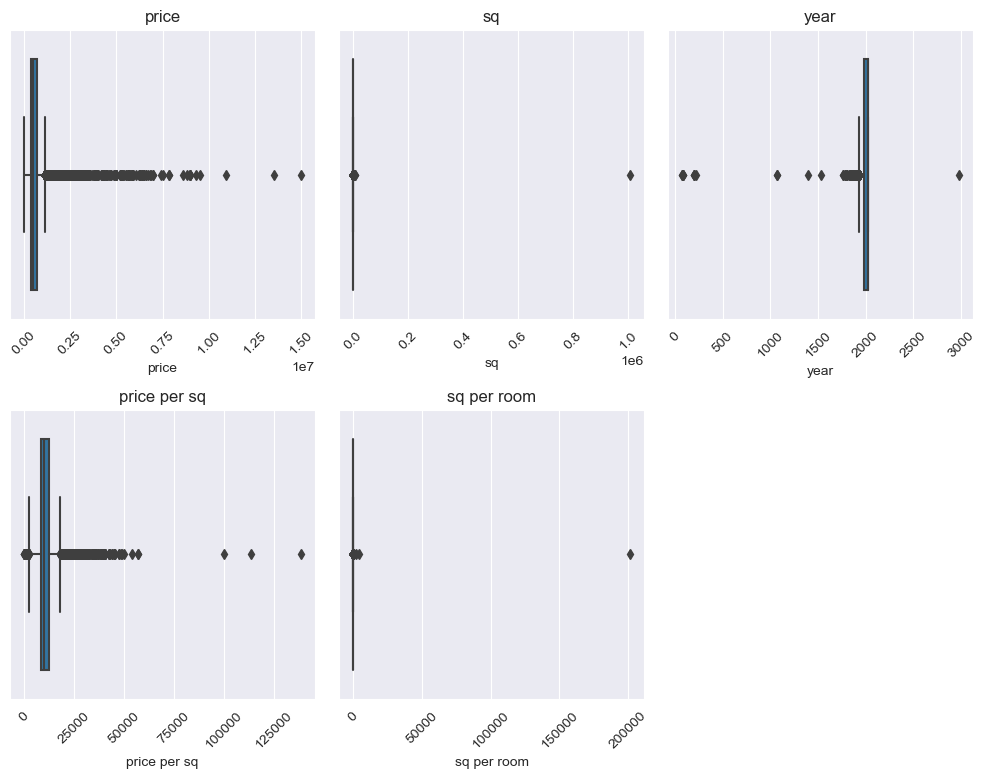

In [38]:
cols = tuple(ndc.columns)
cols_data=(cols[4], cols[6], cols[7], cols[8], cols[9])

labels= ['price', 'sq', 'year', 'price per sq', 'sq per room']

plt.figure(figsize=(10,30))
for i in range(len(cols_data)):
    plt.subplot(8,3,i+1)
    plt.title(labels[i])
    plt.xticks(rotation=45)
    sns.boxplot(ndc[cols_data[i]])

plt.tight_layout()

As we can see, we have huge amount of outliers, we use z-score to handle them.

In [40]:
cols = ['price', 'sq', 'year', 'price per sq', 'sq per room']

z_thresh = 2.7

ndc = ndc[(np.abs(stats.zscore(ndc[cols])) < z_thresh).all(axis=1)]

Now, we can divide the data into 3 cities and perform EDA.

In [41]:
ndc_waw = ndc[ndc["city"].isin(['Warszawa'])]
ndc_kra = ndc[ndc["city"].isin(['Kraków'])]
ndc_poz = ndc[ndc["city"].isin(['Poznań'])]

#### distribution plots for price and price per square meter

##### All 3 cities

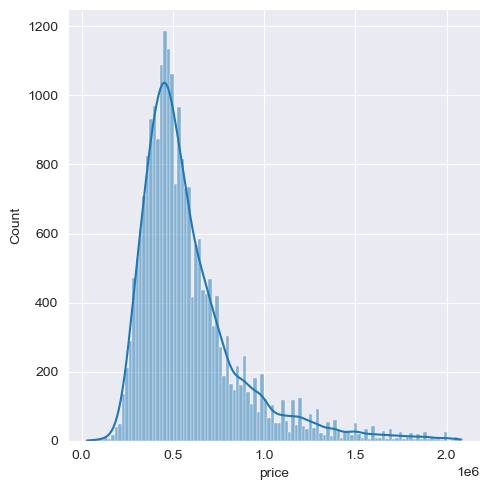

In [42]:
sns.displot(data=ndc['price'], kde=True)

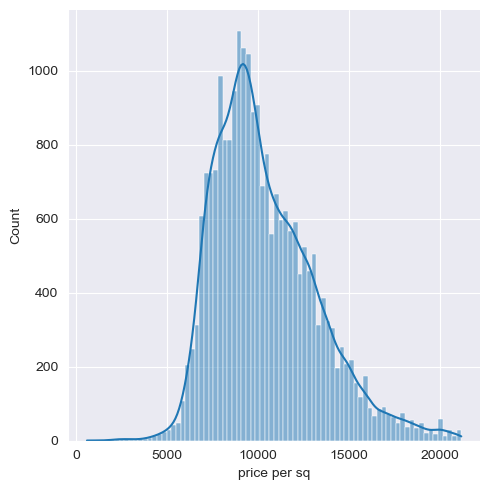

In [43]:
sns.displot(data=ndc['price per sq'], kde=True)

##### Krakow

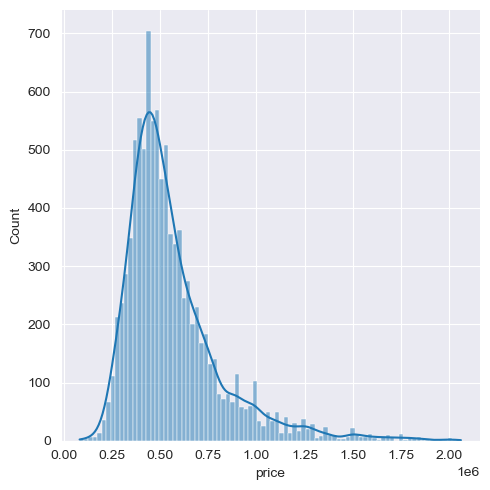

In [44]:
sns.displot(data=ndc_kra['price'], kde=True)

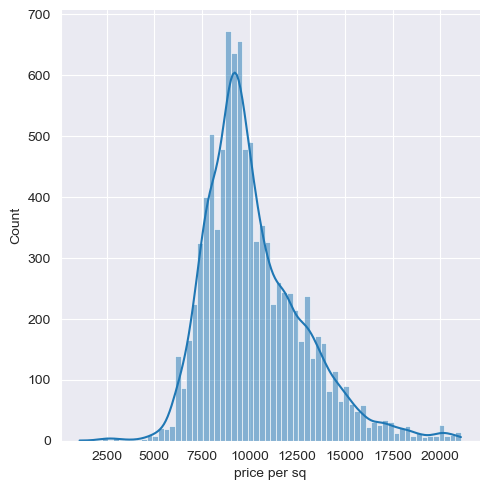

In [45]:
sns.displot(data=ndc_kra['price per sq'], kde=True)

##### Poznan

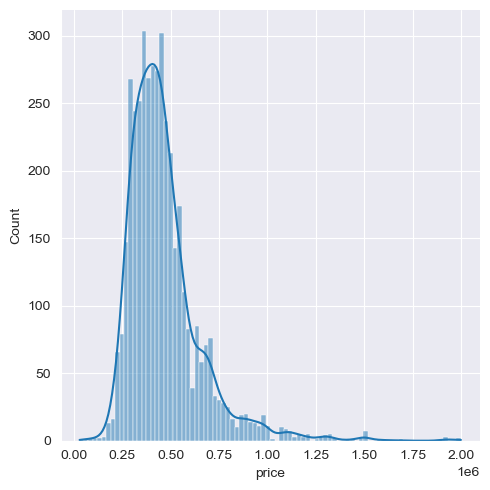

In [46]:
sns.displot(data=ndc_poz['price'], kde=True)

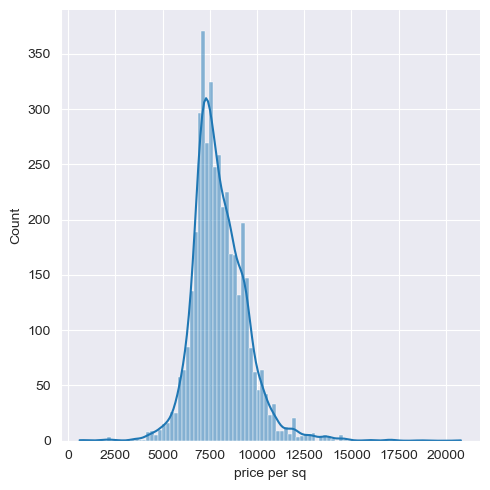

In [47]:
sns.displot(data=ndc_poz['price per sq'], kde=True)

##### Warszawa

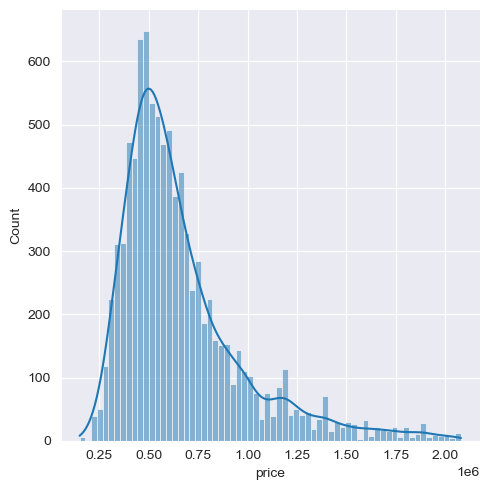

In [48]:
sns.displot(data=ndc_waw['price'], kde=True)

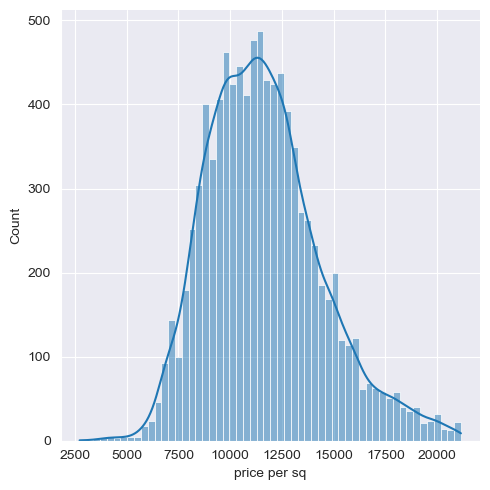

In [49]:
sns.displot(data=ndc_waw['price per sq'], kde=True)

#### Sale price vs year built

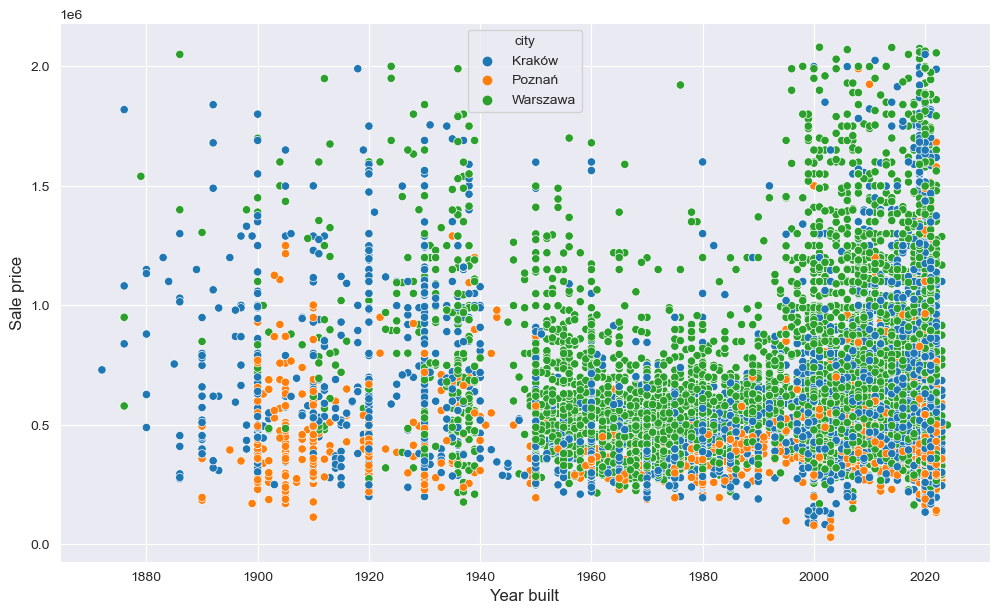

In [50]:
plt.figure(figsize=(12,7))
sns.scatterplot(x='year', y='price', data=ndc, hue='city', hue_order = ['Kraków', 'Poznań', 'Warszawa'])
plt.xlabel('Year built', fontsize = 12)
plt.ylabel('Sale price', fontsize = 12)
plt.show()

#### Sale price vs sq

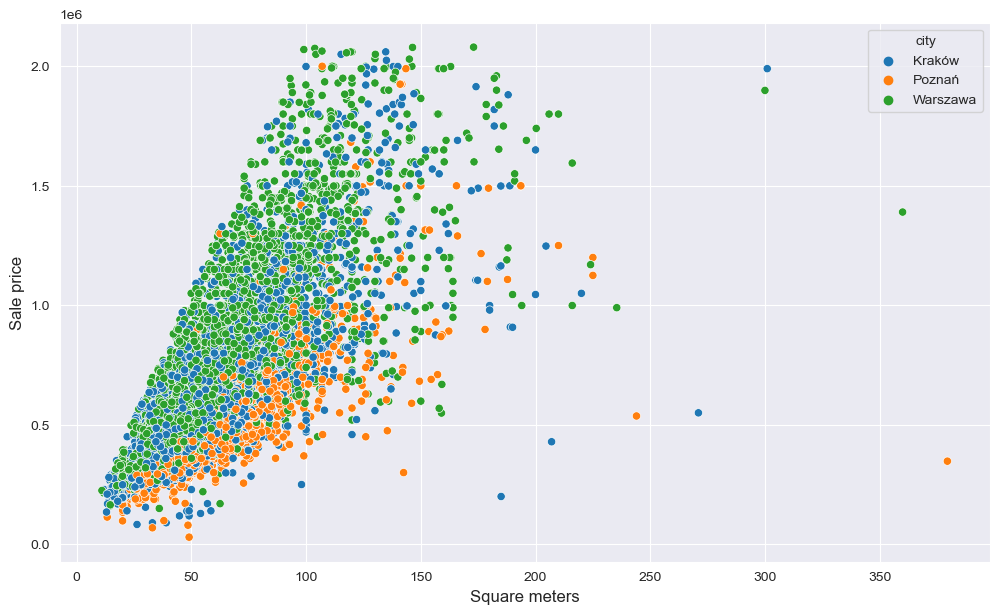

In [51]:
plt.figure(figsize=(12,7))
sns.scatterplot(x='sq', y='price', data=ndc, hue='city', hue_order = ['Kraków', 'Poznań', 'Warszawa'])
plt.xlabel('Square meters', fontsize = 12)
plt.ylabel('Sale price', fontsize = 12)
plt.show()

### City histogram

<AxesSubplot:xlabel='city', ylabel='Count'>

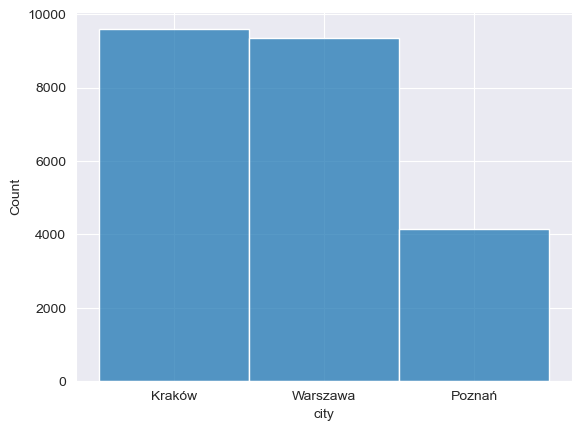

In [52]:
sns.histplot(data=ndc['city'])

#### Heatmap

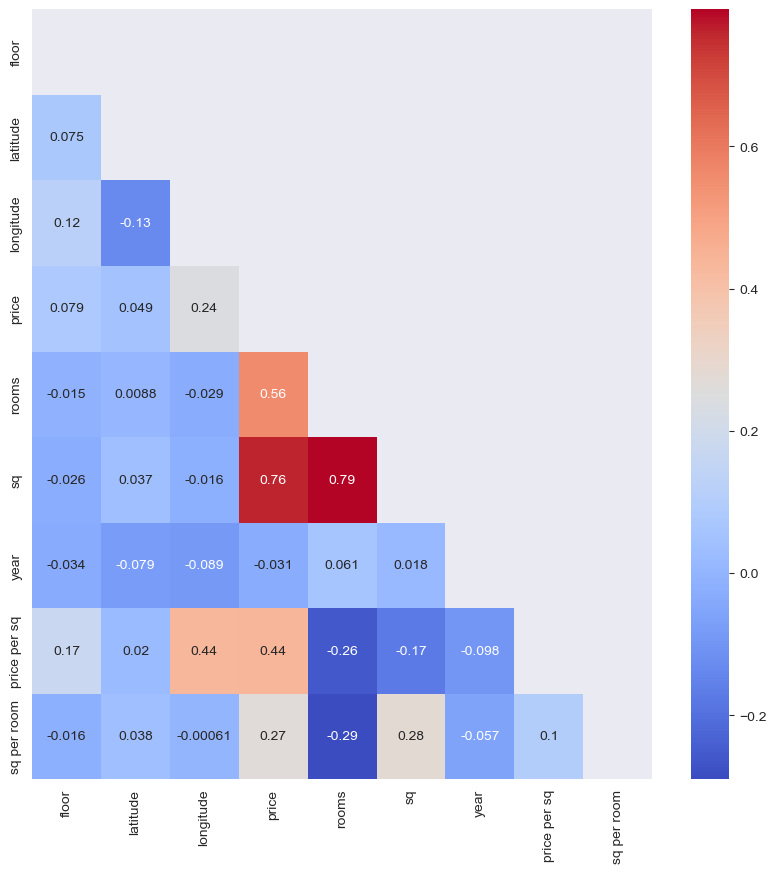

In [53]:
plt.figure(figsize=(10,10))
cor=ndc.corr()
mask = np.triu(np.ones_like(cor, dtype=bool))
sns.heatmap(cor,mask=mask, annot = True, cmap=plt.cm.coolwarm)
plt.show()

### Scikit-learn model


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import  SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [56]:
X_cat = ndc[['city']]
X_num = ndc.drop(['city','latitude', 'longitude', 'price per sq', 'sq per room', 'price'], axis = 1)

X_cat = pd.get_dummies(X_cat)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, index = X_num.index, columns = X_num.columns)
X = pd.concat([X_scaled, X_cat], axis = 1)

y = ndc['price']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= True, test_size=0.25, random_state = 444)

In [59]:
names = ['KernelRidge', 'Linear Regression', 'SGD Regressor', 'K-Nearest Neighbors', 'Decision Tree', 'XGB Regressor']

models = [KernelRidge(), LinearRegression(), SGDRegressor(), KNeighborsRegressor(), DecisionTreeRegressor(), XGBRegressor()]

results = pd.DataFrame(columns = ['R^2'], index = names)
scores_R2=[]

for model in models:

    model.fit(X_train, y_train)

    score = model.score(X_test, y_test)
    scores_R2.append(score)


results['R^2'] = scores_R2
results.sort_values(by = 'R^2', ascending = False)

,R^2
XGB Regressor,0.816875
K-Nearest Neighbors,0.762433
Decision Tree,0.728897
Linear Regression,0.656326
KernelRidge,0.656321
SGD Regressor,0.654905


Let's focus on XGB Regressor

In [60]:
xgb = XGBRegressor()

param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [int(x) for x in np.linspace(10, 100, num = 10)],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0]}


xgb_random = RandomizedSearchCV(xgb, param_grid, n_iter = 100, cv=2,  n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
xgb_random.fit(X_train, y_train)
print('Best Parameters: ', xgb_random.best_params_, ' \n')

Fitting 2 folds for each of 100 candidates, totalling 200 fits
Best Parameters:  {'subsample': 0.5, 'n_estimators': 500, 'max_depth': 40, 'learning_rate': 0.01, 'colsample_bytree': 0.8}  



In [66]:
xgb = XGBRegressor(subsample = 0.5, n_estimators = 500, max_depth = 40, learning_rate = 0.01, colsample_bytree = 0.8)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print(f'final model R^2 score: {xgb.score(X_test, y_test):.3f}')
print(f'final model MAE: {mean_absolute_error(y_test, y_pred):.3f}')

final model R^2 score: 0.838
final model MAE: 66838.451


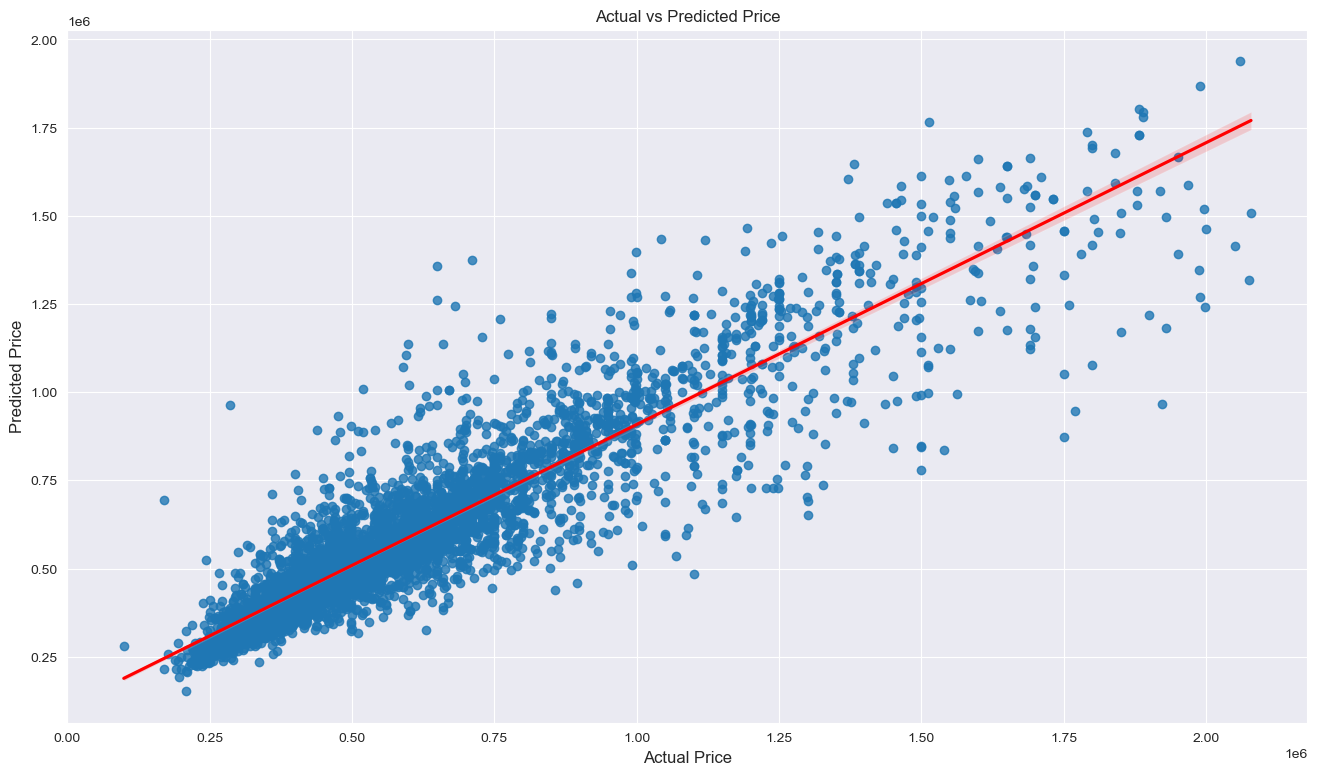

In [69]:
plt.figure(figsize=(16,9))
sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red"})
plt.title("Actual vs Predicted Price", fontsize = 12)
plt.xlabel("Actual Price", fontsize = 12)
plt.ylabel("Predicted Price", fontsize = 12)

plt.show()

We can also visualise feature importance.

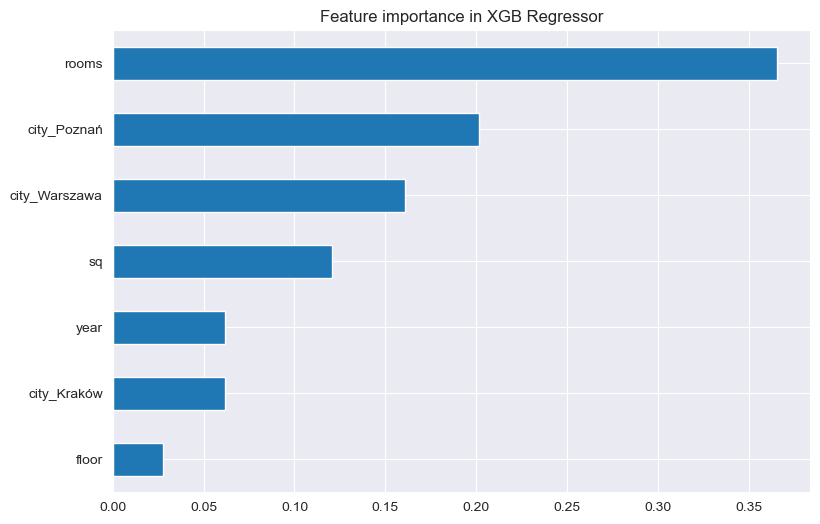

In [72]:
plt.figure(figsize = (9,6))

importances_xgb = pd.Series(xgb.feature_importances_, index = X.columns)
sort = importances_xgb.sort_values()
sort.plot(kind = 'barh')

plt.title('Feature importance in XGB Regressor')
plt.show()